<a href="https://colab.research.google.com/github/ashikaede/CCADMACL_EXERCISES/blob/main/Colocado_Exercise6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [621]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [622]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [623]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


##Data Cleaning and Feature Engineering

In [624]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

# Handle missing values
df['rating'].fillna(df['rating'].mode()[0], inplace=True)  # Fill missing ratings
df['country'].fillna('Unknown', inplace=True)  # Replace missing countries
df = df.dropna(subset=['duration'])  # Remove rows where duration is missing

# Encode categorical variables using Label Encoding
encoder = LabelEncoder()
df['rating_label'] = encoder.fit_transform(df['rating'])
df['country_freq'] = df['country'].map(df['country'].value_counts(normalize=True))
for col in ['country', 'rating']:
    df[col + '_label'] = encoder.fit_transform(df[col])  # Create new encoded column
    df.drop(columns=[col], inplace=True)  # Drop original categorical column



# Convert 'duration' column to numeric values in minutes
def convert_to_minutes(duration):
    try:
        return int(re.findall(r'\d+', duration)[0])
    except (IndexError, ValueError, TypeError):
        return np.nan

df['duration'] = df['duration'].apply(convert_to_minutes)
df['duration'].fillna(df['duration'].median(), inplace=True)  # Fill missing values with median

# Extract primary genre instead of one-hot encoding
df['primary_genre'] = df['listed_in'].str.split(',').str[0].str.strip()
df['primary_genre_label'] = encoder.fit_transform(df['primary_genre'])

# Compute how old the show is
df['show_age'] = 2025 - df['release_year']

# Apply log transformation to duration
df['log_duration'] = np.log1p(df['duration'])

# Drop unnecessary columns
df.drop(columns=['show_id', 'date_added', 'description', 'listed_in', 'cast', 'director', 'title', 'type', 'primary_genre', 'release_year'], inplace=True)


# Display final cleaned dataset
from IPython.display import display
display(df)
print("Final Cleaned Netflix Dataset")


<ipython-input-624-707bafe32e8b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(df['rating'].mode()[0], inplace=True)  # Fill missing ratings
<ipython-input-624-707bafe32e8b>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

,duration,rating_label,country_freq,country_label,primary_genre_label,show_age,log_duration
0,4,8,0.009246,39,16,5,1.609438
1,93,8,0.012842,308,12,9,4.543295
2,78,5,0.002954,379,13,14,4.369448
3,80,4,0.328111,549,0,16,4.394449
4,123,4,0.328111,549,12,17,4.820282
...,...,...,...,...,...,...,...
7782,99,8,0.000128,429,12,20,4.605170
7783,111,6,0.118531,229,12,10,4.718499
7784,44,8,0.065109,669,10,6,3.806662
7785,1,9,0.010659,12,16,6,0.693147


Final Cleaned Netflix Dataset


In [625]:
df.head()


,duration,rating_label,country_freq,country_label,primary_genre_label,show_age,log_duration
0,4,8,0.009246,39,16,5,1.609438
1,93,8,0.012842,308,12,9,4.543295
2,78,5,0.002954,379,13,14,4.369448
3,80,4,0.328111,549,0,16,4.394449
4,123,4,0.328111,549,12,17,4.820282


1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [626]:

# Apply PCA
from sklearn.preprocessing import StandardScaler
# Ensure only numerical features are used
df_numeric = df.select_dtypes(include=[np.number])

# Scale the data before PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)

# Apply PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)
PCA_ds = pd.DataFrame(pca.transform(df_scaled), columns=["col1", "col2"])

# Display explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Explained Variance Ratio: {explained_variance}")
print(f"Cumulative Variance: {cumulative_variance}")

Explained Variance Ratio: [0.35027903 0.22887738]
Cumulative Variance: [0.35027903 0.57915641]


2. Create a scree plot for each principal component

In [627]:
# Scree plot to visualize component importance


explained_variance = pca.explained_variance_ratio_

PC1_explainedvariance = explained_variance[0]
print("Explained variance of PC1", PC1_explainedvariance)

PC2_explainedvariance = explained_variance[1]
print("Explained variance of PC2", PC2_explainedvariance)



Explained variance of PC1 0.35027902798065935
Explained variance of PC2 0.2288773772621811


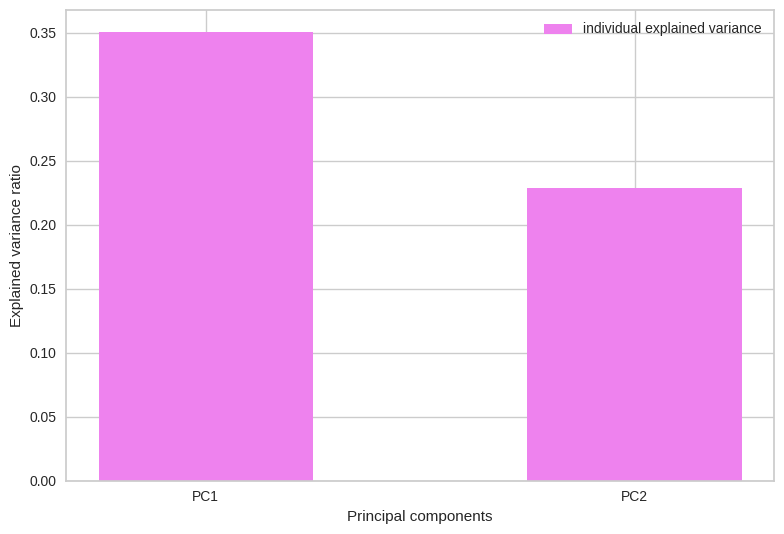

                          PC1       PC2
duration             0.924477  0.021322
rating_label        -0.546556 -0.279510
country_freq        -0.037868  0.869527
country_label       -0.196730  0.823255
primary_genre_label -0.529838  0.232556
show_age             0.419367  0.170269
log_duration         0.895630  0.082866


In [628]:

explained_variance = pca.explained_variance_ratio_

plt.figure()
principalcomponents = ['PC1', 'PC2' ]

plt.bar(principalcomponents, explained_variance[:3], width=0.5, label='individual explained variance', color='violet')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_scaled.columns)

print(loading_matrix)

In [629]:
PC_df = pd.DataFrame(pca.fit_transform(df), columns=['PC1', 'PC2'])
PC_df.head()

,PC1,PC2
0,-361.919995,-82.524174
1,-97.385542,19.166808
2,-25.756415,7.751056
3,143.897726,18.404454
4,141.955524,60.732098


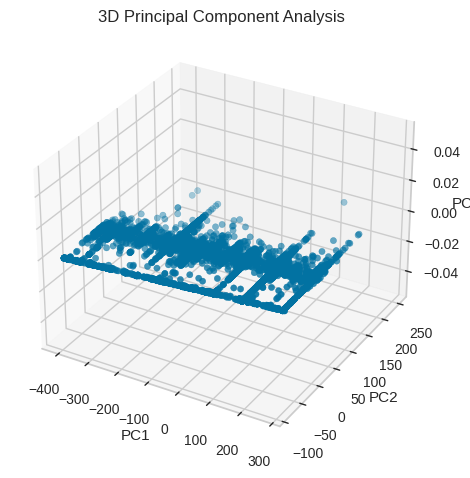

In [630]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC_df['PC1'], PC_df['PC2'])
ax.set_title('3D Principal Component Analysis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

3. Use any clustering algorithm to create clusters

Elbow Method to determine the number of clusters to be formed:


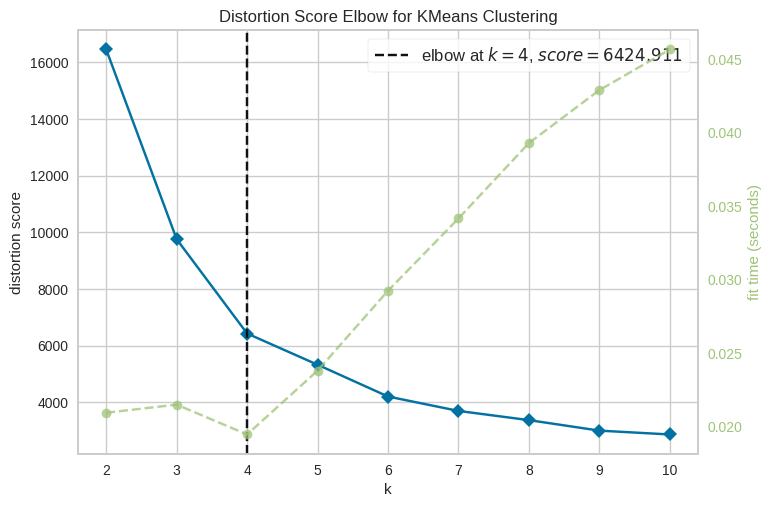

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [631]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [632]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300,
                  n_init = 10, random_state = 0)
kmeans.fit(PCA_ds)
labels = kmeans.labels_  # Cluster labels for each point
centroids = kmeans.cluster_centers_  # Cluster centroids
y_kmeans = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters"]= y_kmeans
df["Clusters"]= y_kmeans

In [633]:
print("Cluster Centroids:\n", centroids)


Cluster Centroids:
 [[ 1.16186051 -0.86992114]
 [-1.93229501  1.17986901]
 [ 0.96174346  1.48428019]
 [-1.65969647 -1.05222895]]


4. Profile each cluster that you have generated based on your experiments

In [634]:
PCA_ds['Cluster'] = labels

In [635]:
cluster_summary = PCA_ds.groupby('Cluster').mean()
print(cluster_summary)

             col1      col2  Clusters
Cluster                              
0        1.162380 -0.869484       0.0
1       -1.932295  1.179869       1.0
2        0.960785  1.484847       2.0
3       -1.659696 -1.052229       3.0


In [636]:
print(PCA_ds.columns)

Index(['col1', 'col2', 'Clusters', 'Cluster'], dtype='object')


<Axes: xlabel='col1', ylabel='col2'>

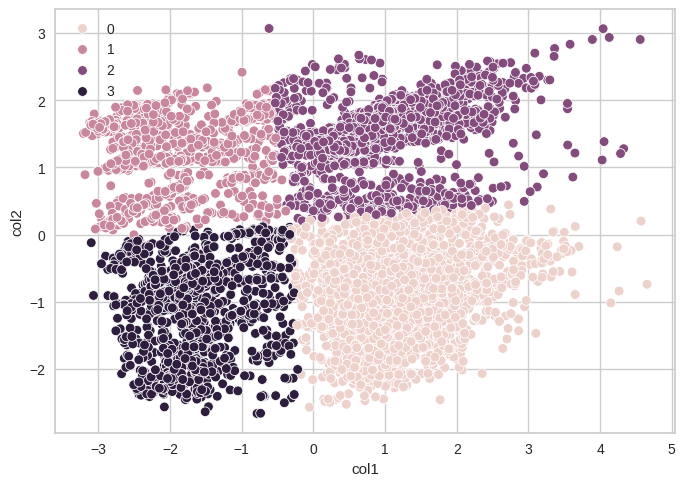

In [637]:
sns.scatterplot(data = PCA_ds, x = 'col1', y = 'col2', hue = kmeans.labels_)

In [638]:
from sklearn.metrics import silhouette_score

score = silhouette_score(PCA_ds[['col1', 'col2']], PCA_ds['Cluster'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5092365875171253


<ipython-input-640-7db5fecdf4b8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=df["Clusters"], palette= pal)


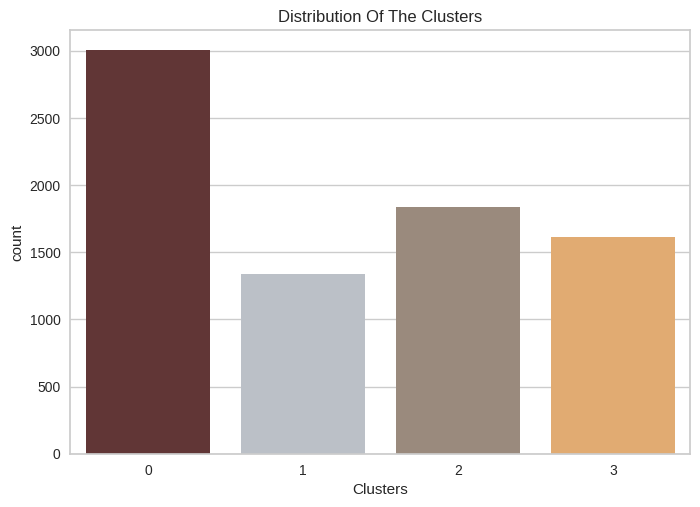

In [640]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

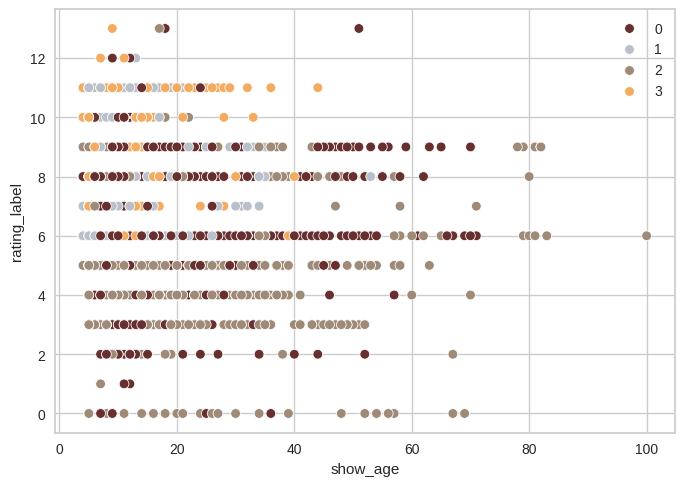

In [643]:
pl = sns.scatterplot(data = df,x=df["show_age"], y=df["rating_label"],hue=df["Clusters"], palette= pal)
plt.legend()
plt.show()

In [667]:
df.head()

,duration,rating_label,country_freq,country_label,primary_genre_label,show_age,log_duration,Clusters
0,4,8,0.009246,39,16,5,1.609438,3
1,93,8,0.012842,308,12,9,4.543295,0
2,78,5,0.002954,379,13,14,4.369448,0
3,80,4,0.328111,549,0,16,4.394449,2
4,123,4,0.328111,549,12,17,4.820282,2


duration


<Figure size 800x550 with 0 Axes>

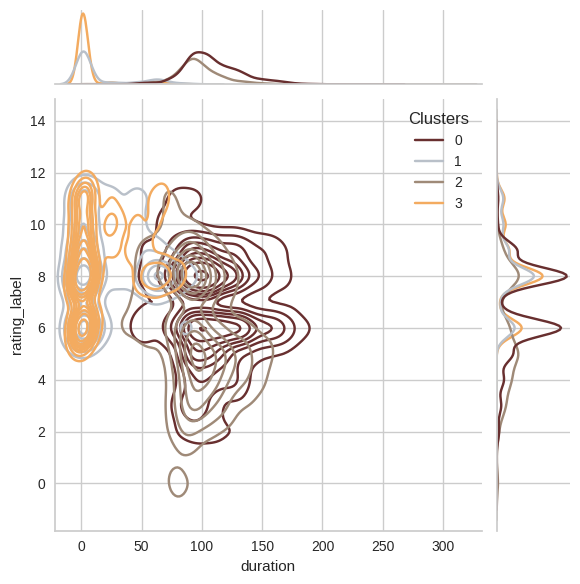

show_age


<Figure size 800x550 with 0 Axes>

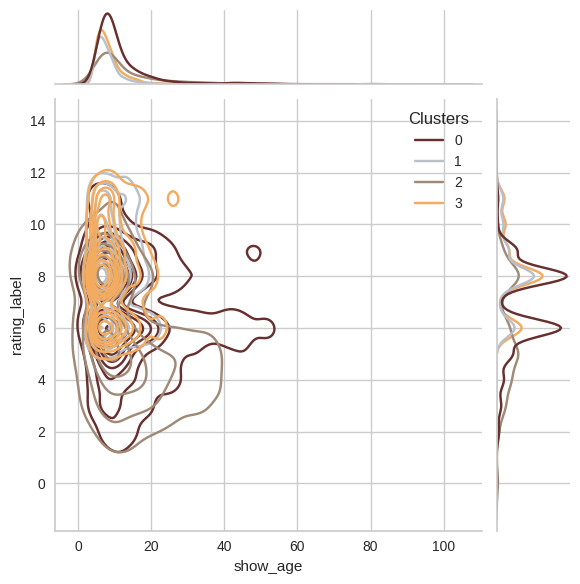

country_label


<Figure size 800x550 with 0 Axes>

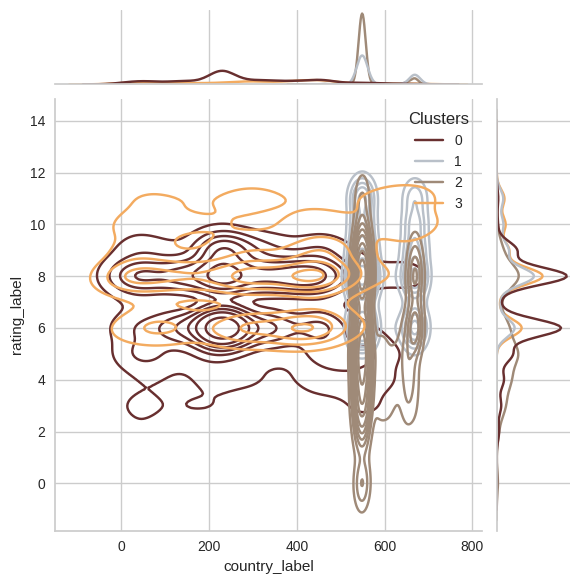

primary_genre_label


<Figure size 800x550 with 0 Axes>

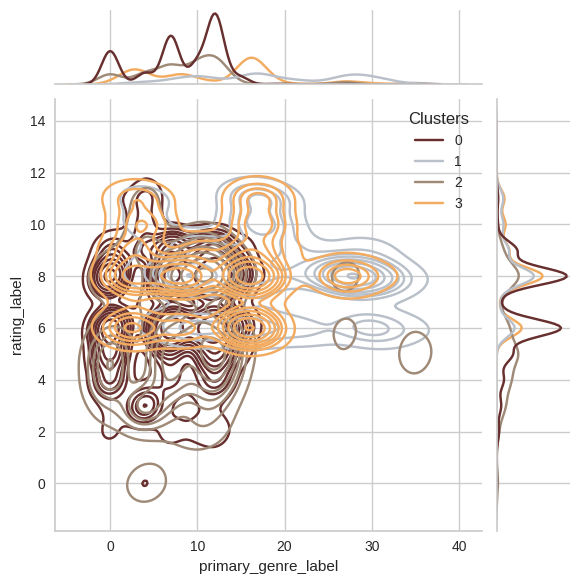

In [671]:
array_list = ["duration",	"show_age",	"country_label", "primary_genre_label"]

for i in array_list:
    print(i)
    plt.figure()
    sns.jointplot(x=df[i], y=df["rating_label"], hue =df["Clusters"], kind="kde", palette=pal)
    plt.show()

## Cluster 0: Mixed & Diverse Content


Content Duration: Wide range, but mostly short to medium duration (0-100 mins).
Show Age: Mix of older and newer content, spanning 10-60 years old.
Country Distribution: Highly international with content from multiple countries.
Genres: Diverse, suggesting general audience appeal.
Rating Labels: Spread across various ratings, suggesting a broad range of content suitability.


## Cluster 1: Newer, High-Rated, & Long-Form Content


Content Duration: Generally longer (90-200+ mins), indicating full-length feature films or extended episodes.
Show Age: Mostly modern content (0-30 years old).
Country Distribution: Broad, but slightly skewed towards international distribution.
Genres: Varied but leans towards critically rated, high-production-value content.
Rating Labels: High concentration in PG-13, R, and TV-MA, indicating mature audience content.

## Cluster 2: Niche & Country-Specific Content


Content Duration: Similar to Cluster 1, it has longer durations (100+ mins).
Show Age: Moderate range but leans towards more recent content.
Country Distribution: More concentrated in specific countries, unlike Cluster 0 & 1.
Genres: Certain genres appear dominant, possibly regional or niche genres.
Rating Labels: Spread out, but includes a good number of TV-14 and TV-MA.



## Cluster 3: Short-Form, Older, & Possibly Classic Content

Content Duration: Mostly short (0-50 mins), significantly different from other clusters.
Show Age: Skews much older (40-100 years old).
Country Distribution: A mix but less diverse than Cluster 0.
Genres: Seems to focus on a specific set of genres, likely classics or educational content.
Rating Labels: Lower range, suggesting family-friendly or non-restrictive content.
